In [77]:
import scanpy as sc
import numpy as np
import scvi
import anndata
import matplotlib.pyplot as plt

In [2]:
lambrechts = sc.read_h5ad("../../data/30_annotate_scrnaseq_data/lambrechts_annotated.h5ad")
maynard = sc.read_h5ad("../../data/30_annotate_scrnaseq_data/maynard_annotated.h5ad")

### gene length normalization for smartseq2

In [3]:
maynard_raw = sc.read_h5ad("../../data/10_public_datasets/Maynard_Bivona_2020_NSCLC/h5ad_raw/maynard2020.h5ad")[maynard.obs_names, :]
lambrechts_raw = sc.read_h5ad("../../data/10_public_datasets/Lambrechts_2018_LUAD/E-MTAB-6653/h5ad_raw/lambrechts_2018_luad_6653.h5ad")[lambrechts.obs_names, :]

In [4]:
gene_lengths = maynard_raw.layers["counts_length_scaled"].data /  maynard_raw.X.data

In [5]:
median_gene_length = np.median(1/ gene_lengths)

In [6]:
maynard_scvi = sc.AnnData(X = np.rint(maynard_raw.layers["counts_length_scaled"] * median_gene_length), var=maynard_raw.var, obs=maynard.obs)

#### Lambrechts

In [27]:
lambrechts_scvi = sc.AnnData(X = lambrechts_raw.X, var=lambrechts_raw.var, obs=lambrechts.obs)
lambrechts_scvi.obs["dataset"] = "Lambrechts_2020_LUAD_6653"
maynard_scvi.obs["dataset"] = "Maynard_Bivona_2020_NSCLC"

In [28]:
adata = anndata.concat([maynard_scvi, lambrechts_scvi])
adata.obs["batch"] = [f"{dataset}_{sample}" for dataset, sample in zip(adata.obs["dataset"], adata.obs["sample"])]

In [29]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="cell_ranger",
    n_top_genes=6000,
    layer="counts",
    batch_key="dataset",
    subset=True
)

... storing 'sample' as categorical
... storing 'patient' as categorical
... storing 'condition' as categorical
... storing 'tissue' as categorical
... storing 'origin' as categorical
... storing 'is_doublet' as categorical
... storing 'leiden' as categorical
... storing 'cell_type' as categorical
... storing 'dataset' as categorical
... storing 'batch' as categorical
/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:504: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:n_top_genes, 'highly_variable'] = True


In [30]:
adata.obs["celltype_in"] = ["Unknown" if dataset.startswith("Lambrechts") else cell_type 
                            for dataset, cell_type in zip(adata.obs["dataset"], adata.obs["cell_type"])]

In [32]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
    labels_key="celltype_in",
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["celltype_in"]                                          
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 43655 cells, 6000 vars, 56        
         batches, 43 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [111]:
lvae = scvi.model.SCANVI(adata, "Unknown", use_cuda=True, n_latent=30, n_layers=1, n_hidden=128)

In [112]:
lvae.train(n_epochs_semisupervised=100)

INFO     Training Unsupervised Trainer for 183 epochs.                                       
INFO     Training SemiSupervised Trainer for 100 epochs.                                     
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 183/183 [09:45<00:00,  3.20s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  585 s. / 183 epochs                                                 
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epochs or reducing the kl warmup.   

In [113]:
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [114]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

In [115]:
sc.set_figure_params(figsize=(10, 10))

In [116]:
adata.uns["C_scANVI_colors"] = np.array(adata.uns["cell_type_colors"])[adata.obs["cell_type"].cat.categories.isin(adata.obs["C_scANVI"].cat.categories)]

AttributeError: Can only use .cat accessor with a 'category' dtype

In [ ]:
sc.pl.umap(adata, color=["cell_type", "C_scANVI", "dataset"], ncols=1, frameon=False, size=10)

In [83]:
df = adata.obs.loc[lambda _: _["dataset"].str.startswith("Lamb"), :].groupby(["cell_type", "C_scANVI"]).size().unstack(fill_value=0)

Text(0, 0.5, 'Observed')

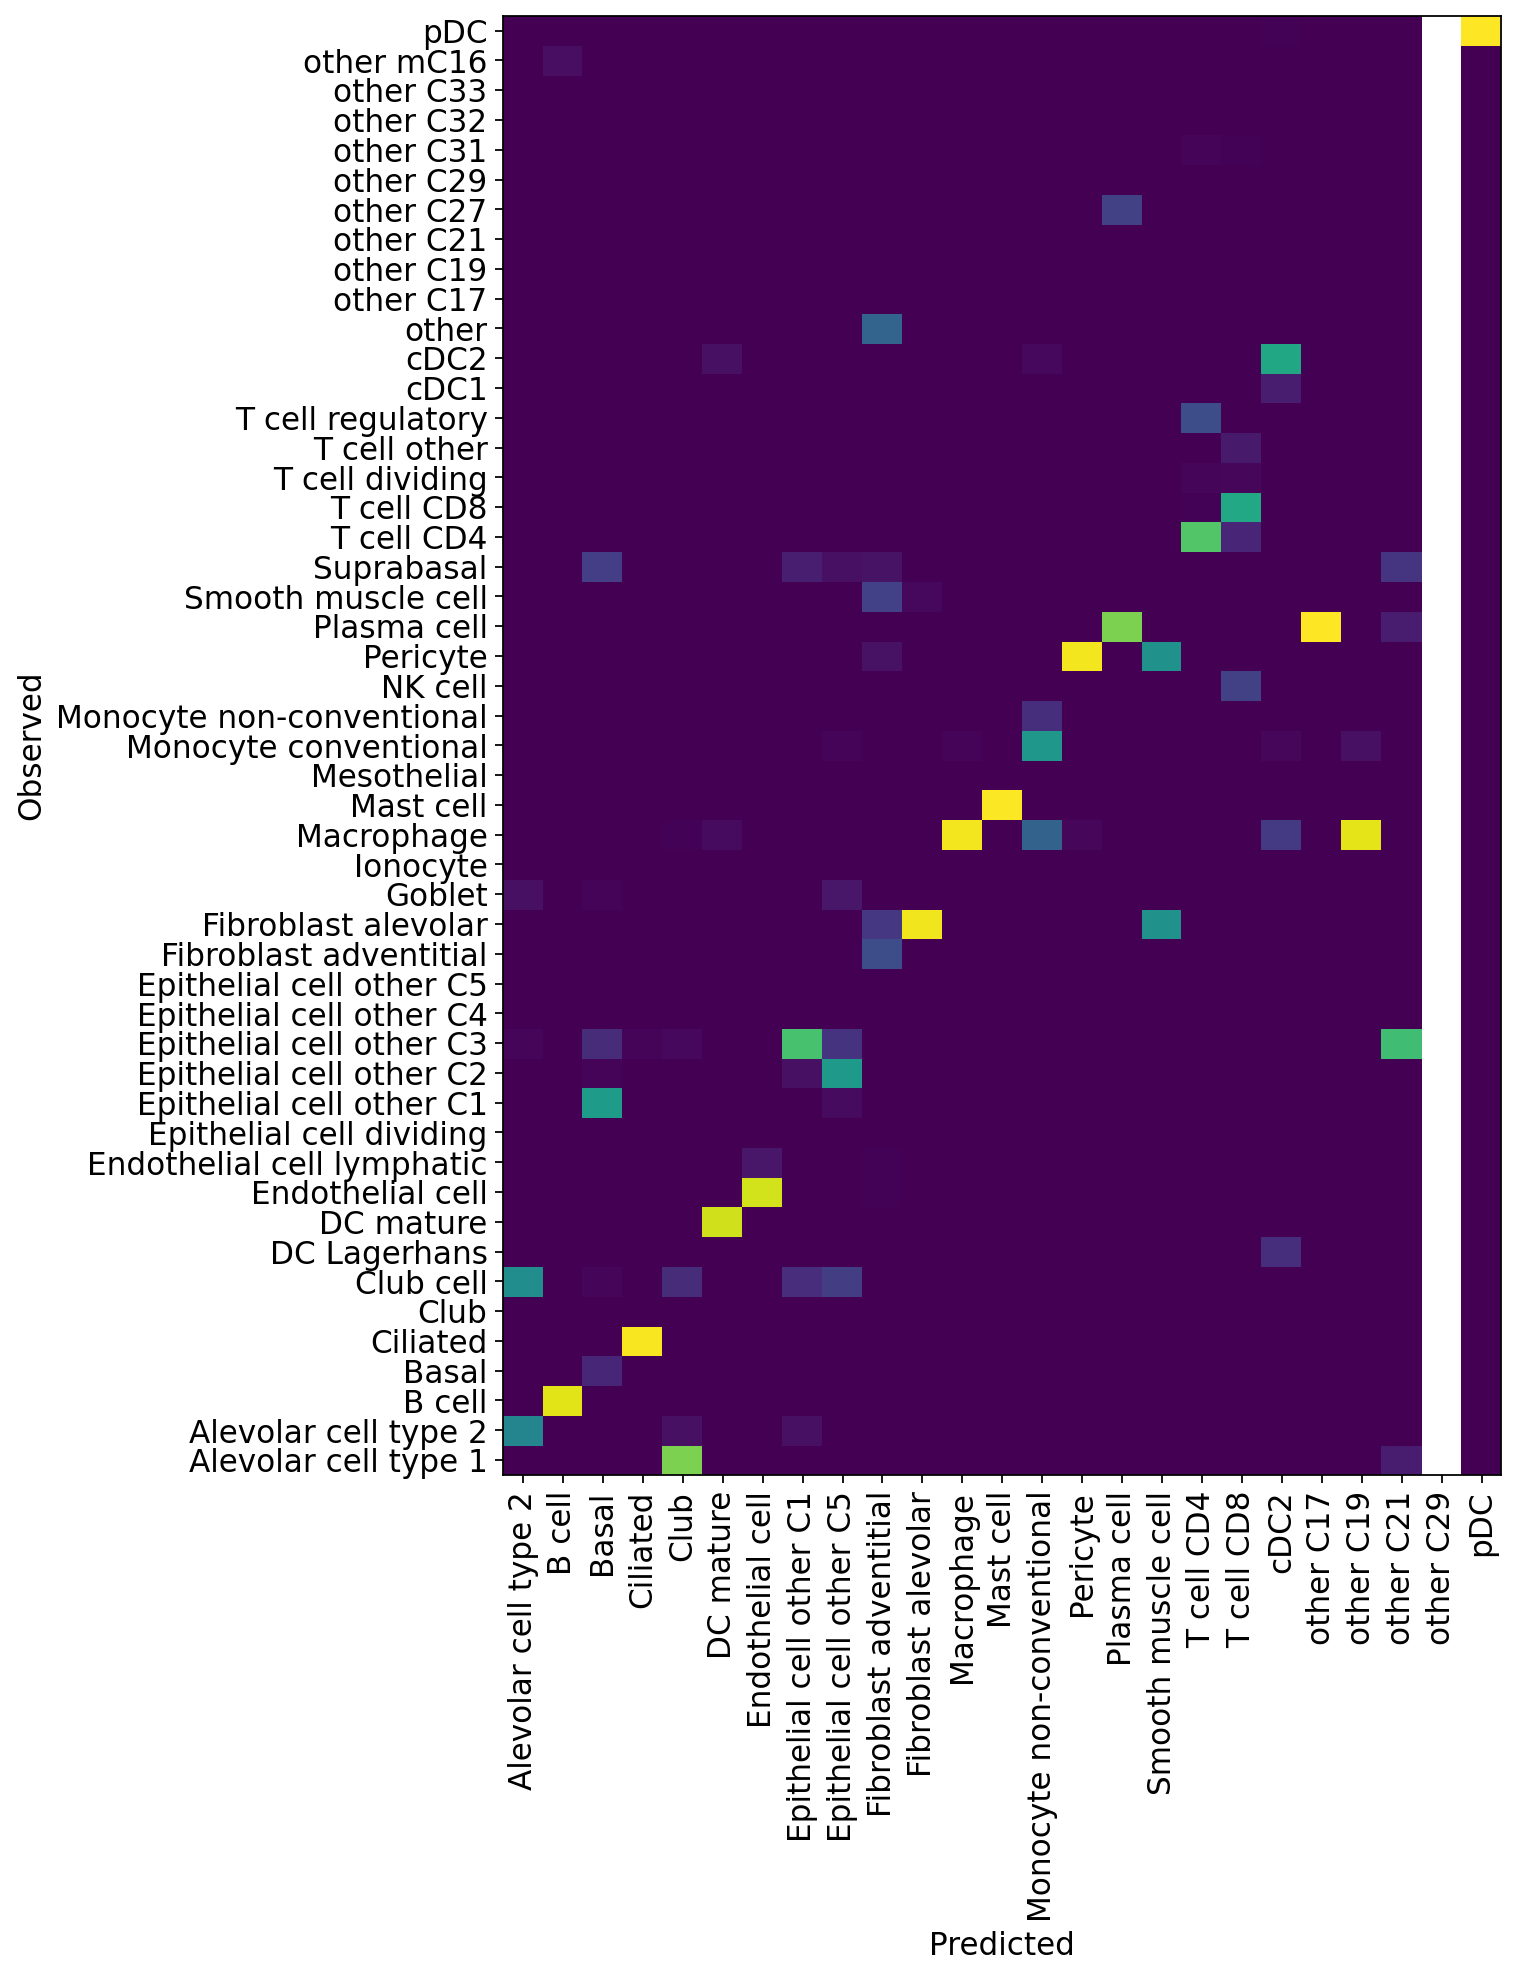

In [84]:
df = df / df.sum(axis=0)

plt.figure(figsize=(8, 12))
_ = plt.pcolor(df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [88]:
adata.obs.rename(columns={"C_scANVI": "cell_type_predicted"}, inplace=True)

In [92]:
adata.write_h5ad("../../data/50_integrate_scrnaseq_data/scanvi_integrated_lambrechts_maynard.h5ad", compression="lzf")

In [90]:
adata_cellxgene = sc.AnnData(X = adata.raw.X, obs=adata.obs, var=adata.raw.var, obsm=adata.obsm)

In [91]:
adata_cellxgene.write_h5ad("../../data/zz_cellxgene/scanvi_integrated_lambrechts_maynard.h5ad", compression="lzf")